## Import data set (using sklearn for this)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder




X, y = fetch_openml(
    "mnist_784", version=1, return_X_y=True, as_frame=False, parser="pandas"
)

X = X/ 255.0
y_enc = OneHotEncoder().fit_transform(y[:, np.newaxis]).toarray()


train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, train_size=train_samples, test_size=10000
)

 

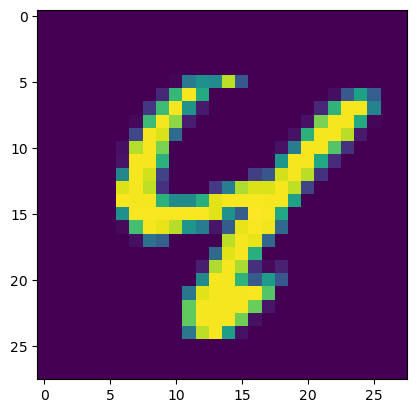

In [41]:
example = np.reshape(X_train[5],[28,28])
plt.imshow(example)

In [42]:
y_train[5]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.])

In [20]:
def relu(x):
    return (x > 0) * x         

def relu2deriv(output):
    return output>0            

def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x/np.sum(e_x, axis = 1) 

In [6]:
import warnings
warnings.filterwarnings("error")

To do :

 
[] add biases (not sure if i did it correctly)

[] Batch stochastic gradient

In [33]:
np.random.seed(1)


alpha = 0.00001
hidden_size = 300

eps = 10**-9

weights_0_1 = 2*np.random.random((28*28,hidden_size)) - 1
bias_1 = np.zeros([1,hidden_size])
bias_2 = np.zeros([1,10])
weights_1_2 = 2*np.random.random((hidden_size,10)) - 1

for iteration in range(60):
   layer_2_error = 0
   for i in range(train_samples):
      layer_0 = X_train[i:i+1]
      layer_1 = relu(np.dot(layer_0,weights_0_1) + bias_1)
      layer_2 = softmax(np.dot(layer_1,weights_1_2) + bias_2)
  
      layer_2_error -= y_train[i:i+1].dot(np.log(layer_2 + eps).T)

      layer_2_delta = -1*y_train[i:i+1]*(1-layer_2)
      layer_1_delta=layer_2_delta.dot(weights_1_2.T)*relu2deriv(layer_1)

      weights_1_2 -= alpha * layer_1.T.dot(layer_2_delta)
      bias_2 -= alpha*layer_2_delta
      weights_0_1 -= alpha * layer_0.T.dot(layer_1_delta)
      bias_1 -= alpha*layer_1_delta

   if(iteration % 10 ==0):
      print("Error:" + str(layer_2_error) + " iter: " + str(iteration))

Error:[[79735.39836585]] iter: 0
Error:[[51945.57546116]] iter: 10
Error:[[38405.10742602]] iter: 20
Error:[[31519.21206756]] iter: 30
Error:[[27108.55524764]] iter: 40
Error:[[24294.10847666]] iter: 50


In [38]:
def predict(X_pred):
    layer_1 = relu(np.dot(X_pred,weights_0_1) + bias_1)
    return softmax(np.dot(layer_1,weights_1_2) + bias_2)


In [43]:
predict(X_train[5])

array([[7.92137868e-105, 1.41999610e-202, 1.80858005e-048,
        5.90005448e-072, 1.00000000e+000, 1.04634172e-063,
        2.73421415e-055, 2.29790369e-044, 2.51242013e-021,
        1.35567798e-015]])

In [44]:
y_test[5]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0.])

In [45]:
predict(X_test[5])

array([[1.78896046e-103, 6.02666207e-115, 7.21604461e-001,
        2.19123324e-016, 2.92241933e-099, 9.88164924e-019,
        3.77099603e-082, 1.33538707e-036, 2.78395539e-001,
        6.53668105e-031]])

Wait did that work? wtf

In [46]:
np.shape(y_test)

(10000, 10)

In [47]:
len(y_test)

10000

In [49]:
corr = 0
for i in range(len(y_test)):
    corr += np.argmax(y_test[i]) == np.argmax(predict(X_test[i]))

corr/len(y_test)

0.7298

Thats not bad at all for absolutely NO hypertuning

Look at weights. in the hidden layer we have 300 'images' that give dotted with the image. 

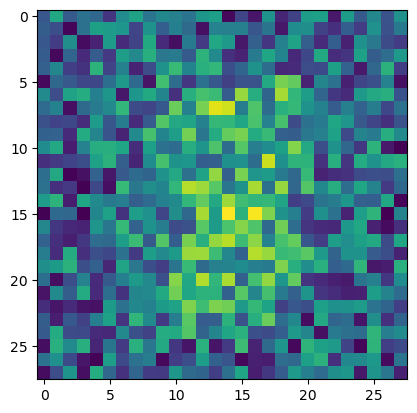

Most of them are pretty meaningless, however the one i show above does look like ot should correlate strongly with the three. Odd

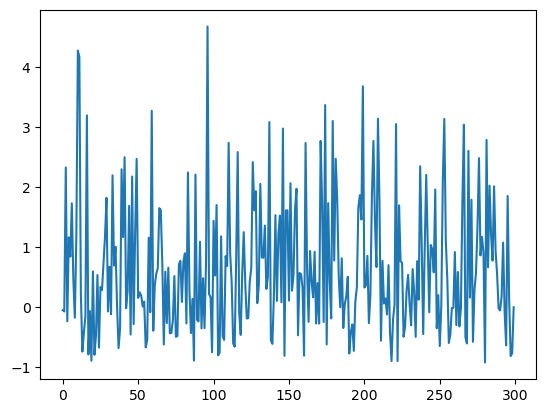

In [62]:
plt.plot(weights_1_2[:,2]) 

In [74]:
np.argsort(weights_1_2[:,2])[-3:]

array([11, 10, 96], dtype=int64)

96 is the most important hidden layer neuron

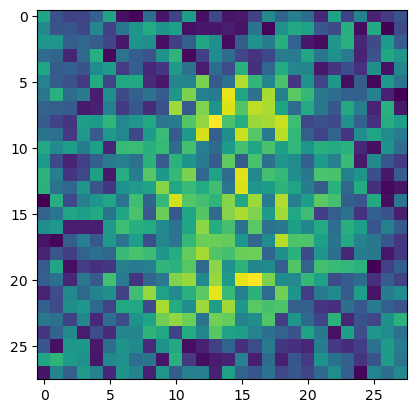

In [64]:
plt.imshow(np.reshape(weights_0_1[:,96],[28,28]))

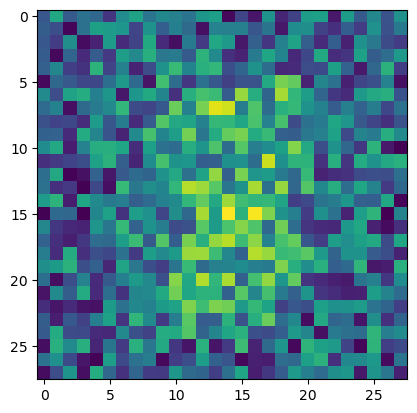

In [75]:
plt.imshow(np.reshape(weights_0_1[:,10],[28,28]))

Interesting! these do look vaguely 3 ish..

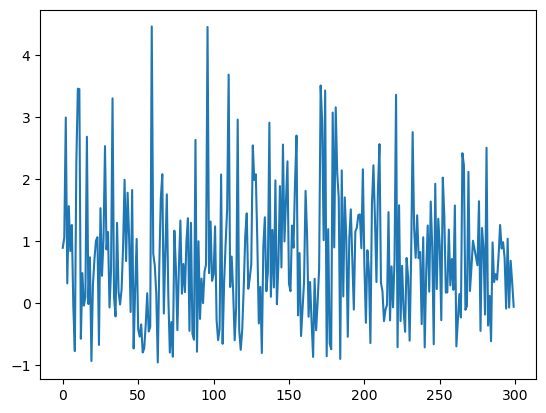

In [65]:
plt.plot(weights_1_2[:,5])

In [66]:
np.argmax(weights_1_2[:,5])

59

In [70]:
np.argsort(weights_1_2[:,5])[-2:]

array([96, 59], dtype=int64)

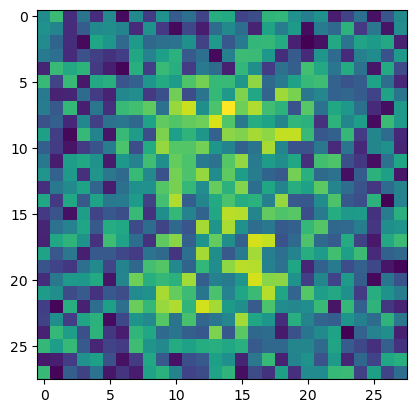

In [67]:
plt.imshow(np.reshape(weights_0_1[:,59],[28,28]))

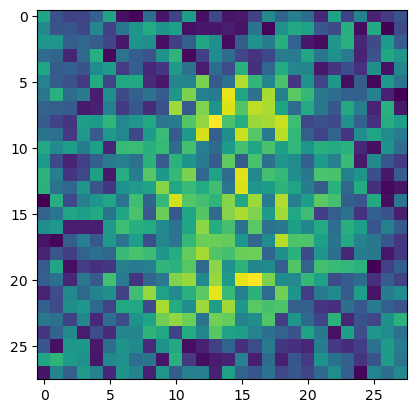

In [71]:
plt.imshow(np.reshape(weights_0_1[:,96],[28,28]))

I guess these correlate with 4's ;)